In [23]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
import datetime as dt

from statsmodels.graphics.tsaplots import acf, pacf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller



# ETH

## Step #1: Read Data

In [24]:
# Read data
df = pd.read_csv('../../../Dataset/ETH-USD.csv', parse_dates=['Date'])
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-03-01,856.012024,880.302002,851.919983,872.200012,872.200012,1868519936
1,2018-03-02,871.763977,876.377991,852.421997,856.853027,856.853027,1894419968
2,2018-03-03,856.710999,868.453979,855.206970,857.224976,857.224976,1699369984
3,2018-03-04,856.185974,867.950012,840.280029,866.677979,866.677979,1697939968
4,2018-03-05,866.846008,869.919983,853.520020,853.684021,853.684021,1898489984
...,...,...,...,...,...,...,...
2280,2024-05-28,3892.096924,3924.895752,3771.213867,3840.256348,3840.256348,19846044324
2281,2024-05-29,3840.235107,3880.648438,3742.041260,3763.196533,3763.196533,17411416736
2282,2024-05-30,3763.357666,3823.643311,3702.263672,3746.849609,3746.849609,15065849797
2283,2024-05-31,3746.861572,3843.857666,3723.835205,3760.026611,3760.026611,15290700646


## Step #2: Explore the Data

In [25]:
# Dataset Description
df = df.set_index('Date')
print(f"Dataset Shape: {df.shape}")
print(f"Dataset Info: {df.info()}")
print(f"Dataset Describe: {df.describe()}")

Dataset Shape: (2285, 6)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2285 entries, 2018-03-01 to 2024-06-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2285 non-null   float64
 1   High       2285 non-null   float64
 2   Low        2285 non-null   float64
 3   Close      2285 non-null   float64
 4   Adj Close  2285 non-null   float64
 5   Volume     2285 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 125.0 KB
Dataset Info: None
Dataset Describe:               Open         High          Low        Close    Adj Close  \
count  2285.000000  2285.000000  2285.000000  2285.000000  2285.000000   
mean   1382.223052  1420.299282  1340.640632  1383.338951  1383.338951   
std    1196.928005  1231.006843  1159.155324  1197.594531  1197.594531   
min      84.279694    85.342743    82.829887    84.308296    84.308296   
25%     232.898697   239.115906   228.492996   233.028275   233.028275  

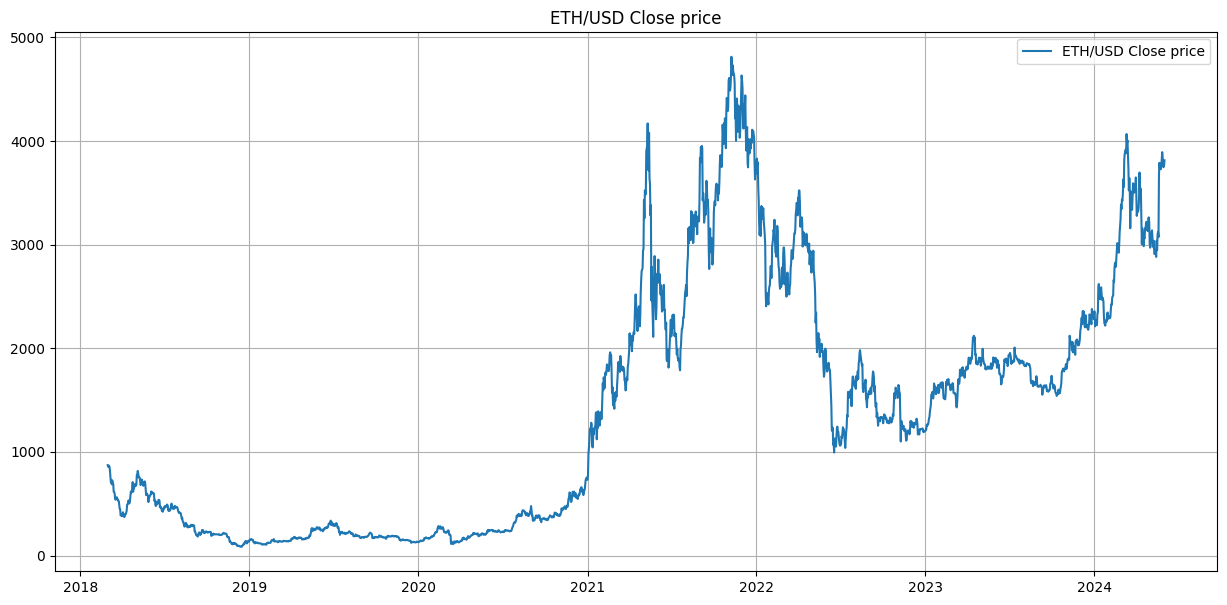

In [26]:
# Plotting data
plt.figure(figsize=(15, 7))
plt.plot(df.Close, label='ETH/USD Close price')
plt.title('ETH/USD Close price')
plt.grid()
plt.legend()
plt.show()


## Step #3: Feature Engineering

In [27]:
# Feature Engineering
def createFeatures(df):
    df = pd.DataFrame(df)

    
    # df['Close_Diff'] = df['Adj Close'].diff()
        
    # Moving averages - different periods
    df['MA200'] = df['Close'].rolling(window=200).mean() 
    df['MA100'] = df['Close'].rolling(window=100).mean() 
    df['MA50'] = df['Close'].rolling(window=50).mean() 
    df['MA26'] = df['Close'].rolling(window=26).mean() 
    df['MA20'] = df['Close'].rolling(window=20).mean() 
    df['MA12'] = df['Close'].rolling(window=12).mean() 
    
    # SMA Differences - different periods
    df['DIFF-MA200-MA50'] = df['MA200'] - df['MA50']
    df['DIFF-MA200-MA100'] = df['MA200'] - df['MA100']
    df['DIFF-MA200-CLOSE'] = df['MA200'] - df['Close']
    df['DIFF-MA100-CLOSE'] = df['MA100'] - df['Close']
    df['DIFF-MA50-CLOSE'] = df['MA50'] - df['Close']
    
    # Moving Averages on high, lows, and std - different periods
    # df['MA200_low'] = df['Low'].rolling(window=200).min()
    # df['MA14_low'] = df['Low'].rolling(window=14).min()
    # df['MA200_high'] = df['High'].rolling(window=200).max()
    # df['MA14_high'] = df['High'].rolling(window=14).max()
    df['MA20dSTD'] = df['Close'].rolling(window=20).std() 
    
    # Exponential Moving Averages (EMAS) - different periods
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['EMA100'] = df['Close'].ewm(span=100, adjust=False).mean()
    df['EMA200'] = df['Close'].ewm(span=200, adjust=False).mean()

    # Shifts (one day before and two days before)
    df['close_shift-1'] = df.shift(-1)['Close']
    df['close_shift-2'] = df.shift(-2)['Close']

    # Bollinger Bands
    df['Bollinger_Upper'] = df['MA20'] + (df['MA20dSTD'] * 2)
    df['Bollinger_Lower'] = df['MA20'] - (df['MA20dSTD'] * 2)
    df['Bollinger_Middle'] = df['MA20'] 
    
    # Relative Strength Index (RSI)
    # df['K-ratio'] = 100*((df['Close'] - df['MA14_low']) / (df['MA14_high'] - df['MA14_low']) )
    # Relative Strength Index (RSI) not using the K-ratio
    # df['RSI'] = df['K-ratio'].rolling(window=3).mean() 

    # Moving Average Convergence/Divergence (MACD)
    df['MACD'] = df['EMA12'] - df['EMA26']
    
    # Replace nas 
    nareplace = df.at[df.index.max(), 'Close']    
    df.fillna((nareplace), inplace=True)

    return df

                  Close  MACD_shift-1  Bollinger_Upper_shift-1  Bollinger_Lower_shift-1  MA26_shift-1  EMA20_shift-1
Date                                                                                                                
2024-05-28  3840.256348    197.379449              4100.867626              2501.410133   3247.639207    3449.526200
2024-05-29  3763.196533    202.804997              4163.170314              2525.767357   3280.411818    3486.738595
2024-05-30  3746.849609    198.597393              4206.411423              2555.243850   3305.783147    3513.067923
2024-05-31  3760.026611    191.733590              4232.438059              2612.923050   3329.985962    3535.332845
2024-06-01  3813.198975    185.222126              4250.658131              2679.545433   3353.938946    3556.732251
                 Close  MACD_shift-1  Bollinger_Upper_shift-1  Bollinger_Lower_shift-1  MA26_shift-1  EMA20_shift-1
Date                                                             

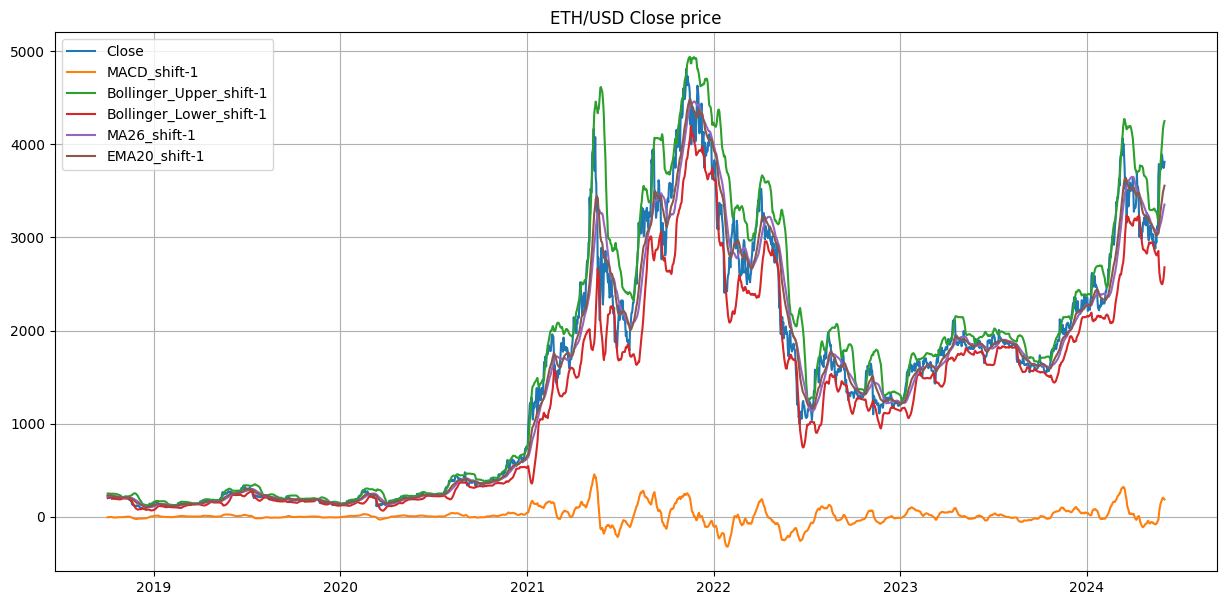

In [28]:
# List of considered Features
FEATURES = [
            # 'High',
            # 'Low',
            # 'Open',
            'Close',
            # 'Volume',
#             'Day',
#             'Month',
#             'Year',
            # 'Adj Close',
#              'close_shift-1',
#              'close_shift-2',
            'MACD',
            # 'RSI',
            # 'MA200',
#             'MA200_high',
#             'MA200_low',
            'Bollinger_Upper',
            'Bollinger_Lower',
            # 'MA100',            
#             'MA50',
            'MA26',
#             'MA14_low',
#             'MA14_high',
            # 'MA12',
            'EMA20',
            # 'EMA100',
#             'EMA200',
#               'DIFF-MA200-MA50',
#               'DIFF-MA200-MA100',
#             'DIFF-MA200-CLOSE',
#             'DIFF-MA100-CLOSE',
#             'DIFF-MA50-CLOSE',
            # 'MA20dSTD',
            # 'Close_Diff',
            # 'K-ratio'
           ]

# Create the dataset with features
df_features = createFeatures(df)

# Shift the timeframe by 10 month -> Start date is 2010-11-01
use_start_date = pd.to_datetime("2018-10-01")
df_features = df_features[df_features.index > use_start_date].copy()

# Filter the data to the list of FEATURES
df_filtered = df_features[FEATURES].copy()

df_original = df_filtered.copy()

# Create shifted features
for feature in FEATURES:
    if feature != 'Close':
        df_filtered[feature + '_shift-1'] = df_filtered[feature].shift(1)
        df_filtered = df_filtered.drop(feature, axis=1)

df_filtered = df_filtered.dropna()


print(df_filtered.tail().to_string())
print(df_filtered.head().to_string())
print(df_original.head().to_string())
print(df_original.tail().to_string())

# Create the lineplot
plt.figure(figsize=(15, 7))
plt.plot(df_filtered)
plt.title('ETH/USD Close price')
plt.grid()
plt.legend(df_filtered.columns)
plt.show()


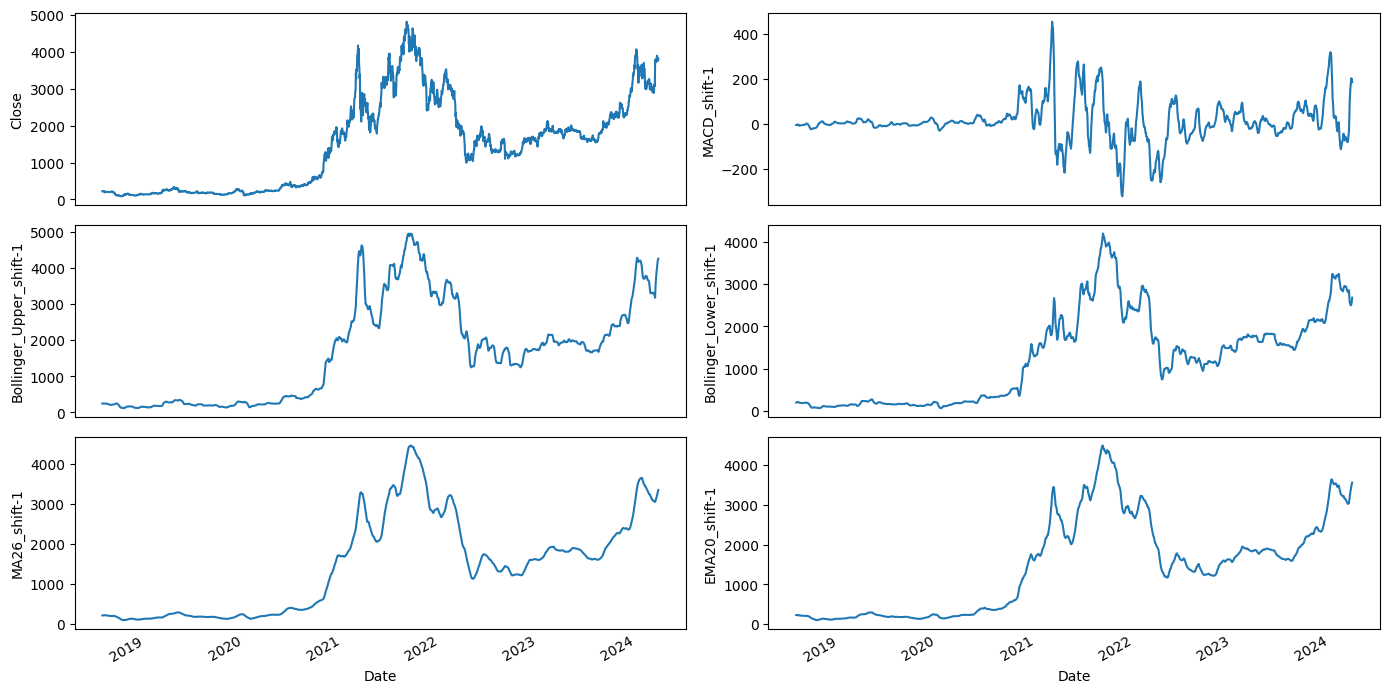

In [29]:
# Plot line charts
df_plot = df_filtered.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

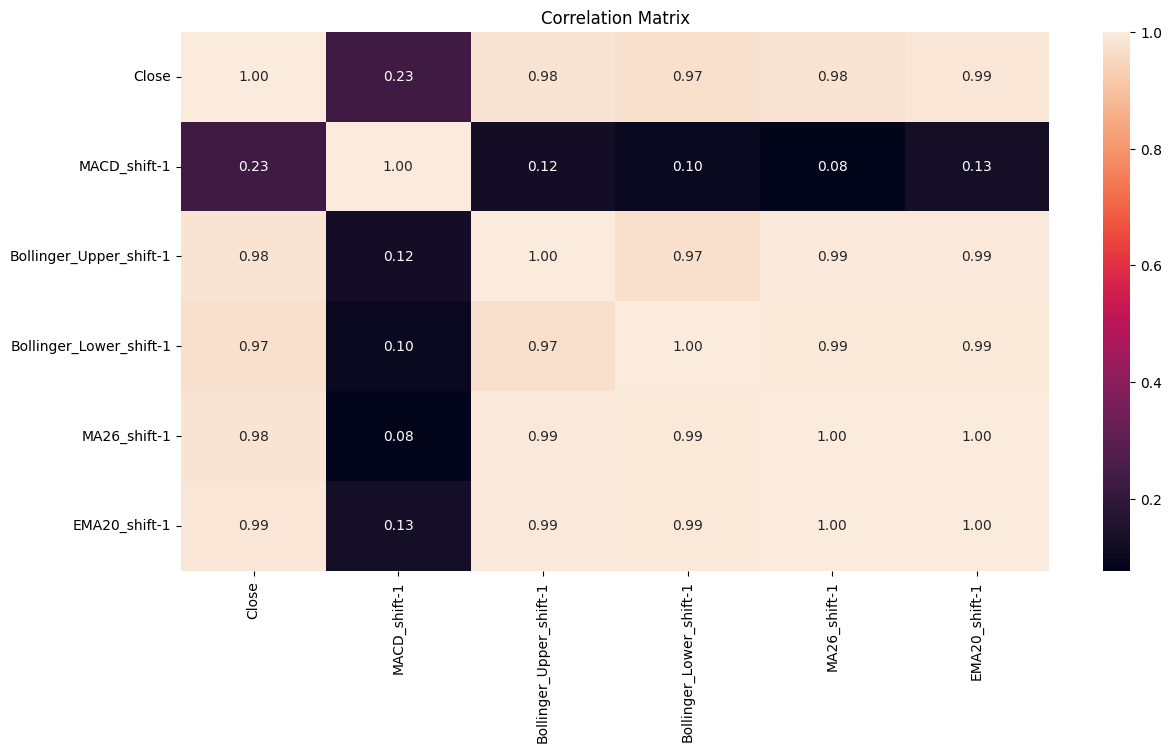

In [30]:
# Coorelation Matrix
plt.figure(figsize=(14, 7))
sns.heatmap(df_filtered.corr(), annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [31]:
# Granger causality test to check if the past values of the time series affect the current value of the time series
from statsmodels.tsa.stattools import grangercausalitytests
maxlag = 24
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1], 4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)



,Open_x,High_x,Low_x,Close_x,Adj Close_x,Volume_x
Open_y,1.0,0.0,0.0,0.0,0.0,0.0
High_y,0.0,1.0,0.0,0.0,0.0,0.0
Low_y,0.0,0.0,1.0,0.0,0.0,0.0
Close_y,0.0,0.0,0.0,1.0,1.0,0.0
Adj Close_y,0.0,0.0,0.0,1.0,1.0,0.0
Volume_y,0.0,0.0,0.0,0.0,0.0,1.0


## Step #4: Train & Test split

In [32]:
# Train-Test Split
def split_data(df, test_size=None):
    test_size = 0.2 if test_size is None else test_size
    split_row = len(df) - int(test_size * len(df))
    train_set = df.iloc[:split_row].copy()
    test_set = df.iloc[split_row:].copy()
    return train_set, test_set

df_train, df_test = split_data(df_filtered, test_size=0.2) 

In [33]:
print(df_filtered.shape)
print(df_train.shape)
print(df_test.shape)

(2069, 6)
(1656, 6)
(413, 6)


## Step #5: Model Specification

**VAR**

**1. Check for stationary**

In [34]:
# Agugmented Dickey-Fuller test
def adf_test(dataset, name):
    dftest = adfuller(dataset, autolag='AIC', regression='ct')
    print(f"ADF Test on '{name}' -> p-value: {dftest[1]:.3f}")
    # print("1. ADF : ",dftest[0])
    # Print dataset cols
    # print("3. Num Of Lags : ", dftest[2])
    # print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
    # # print("5. Critical Values :")
    # for key, val in dftest[4].items():
    #    print("\t",key, ": ", val)
    if (dftest[0] < dftest[4]["5%"] or dftest[0] < dftest[4]["1%"] or dftest[0] < dftest[4]["10%"]):
        print ("\033[92mReject Ho - Time Series is Stationary\033[0m")
        return True
    else:
        print ("\033[91mFailed to Reject Ho - Time Series is Non-Stationary\033[0m")
        return False
      

In [35]:
# ADF Test on each column of 1st Differences Dataframe
for col in df_train.columns:
    adf_test(df_train[col], col)

ADF Test on 'Close' -> p-value: 0.765
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'MACD_shift-1' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'Bollinger_Upper_shift-1' -> p-value: 0.787
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'Bollinger_Lower_shift-1' -> p-value: 0.595
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'MA26_shift-1' -> p-value: 0.884
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'EMA20_shift-1' -> p-value: 0.623
Failed to Reject Ho - Time Series is Non-Stationary


In [36]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [37]:
# ADF Test on each column of 1st Differences Dataframe
for col in df_differenced.columns:
    adf_test(df_differenced[col], col)
    

ADF Test on 'Close' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'MACD_shift-1' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'Bollinger_Upper_shift-1' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'Bollinger_Lower_shift-1' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'MA26_shift-1' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'EMA20_shift-1' -> p-value: 0.000
Reject Ho - Time Series is Stationary


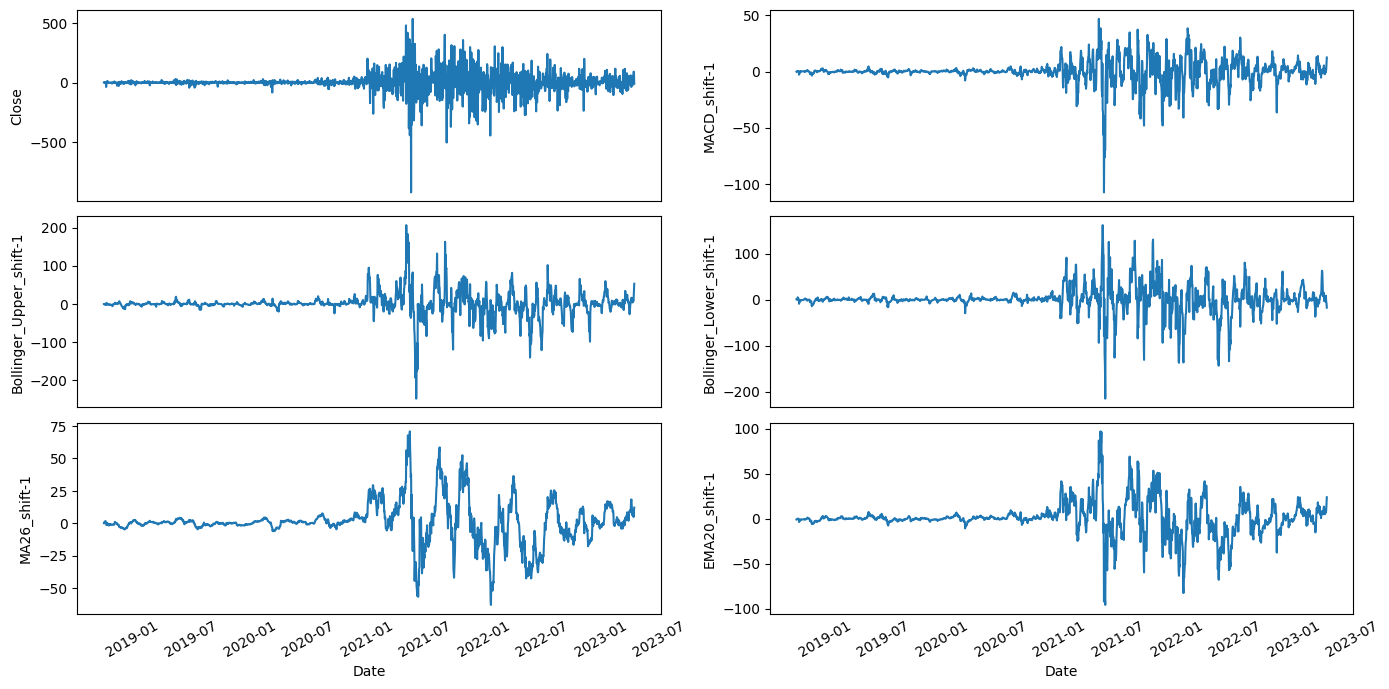

In [38]:
# Plot line charts
df_plot = df_differenced.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

Text(0.5, 1.0, 'ACF')

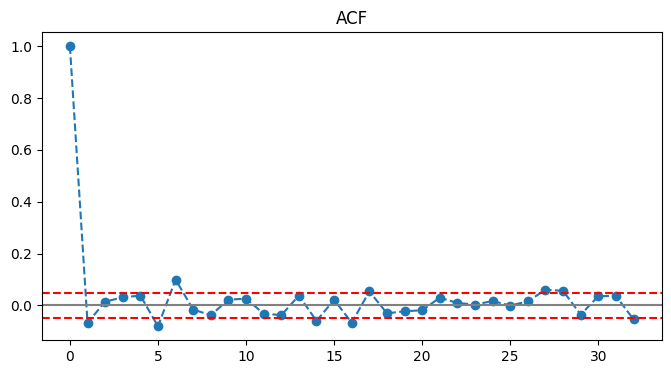

In [39]:
import statsmodels.tsa.stattools as ts
acf_plot = ts.acf(df_differenced['Close'])
# Plot ACF
plt.figure(figsize=(8, 4))
plt.plot(acf_plot, marker='o', linestyle='--')
plt.axhline(y=0, color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_differenced)), color='red', linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(df_differenced)), color='red', linestyle='--')
plt.title('ACF')

In [40]:
model = VAR(df_differenced)
sorted_order = model.select_order(maxlags=17)
print(sorted_order.summary())


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        33.62       33.64   3.989e+14       33.63
1       -44.76      -44.62   3.650e-20      -44.71
2       -96.12      -95.86   1.806e-42      -96.02
3       -96.95      -96.57   7.889e-43      -96.81
4       -97.20      -96.71   6.116e-43      -97.02
5       -97.39      -96.78   5.052e-43      -97.16
6       -157.5      -156.8   3.955e-69      -157.2
7       -157.8      -156.9   3.033e-69      -157.5
8       -157.5      -156.5   3.896e-69      -157.2
9       -158.3     -157.3*   1.706e-69      -157.9
10      -157.5      -156.3   4.045e-69      -157.0
11      -157.3      -155.9   5.002e-69      -156.8
12      -158.6      -157.2   1.326e-69      -158.1
13      -158.5      -156.9   1.481e-69      -157.9
14      -158.3      -156.6   1.866e-69      -157.6
15      -158.6      -156.8   1.304e-69      -157.9
16      -158.8      -156.9   1.

In [41]:
# Fỉt VAR model
model_fitted = model.fit(17)
print(model_fitted.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 11, Jun, 2024
Time:                     08:32:21
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -156.930
Nobs:                     1638.00    HQIC:                  -158.212
Log likelihood:           116867.    FPE:                9.15744e-70
AIC:                     -158.967    Det(Omega_mle):     6.35134e-70
--------------------------------------------------------------------
Results for equation Close
                                        coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------------------
const                                      1.225697         1.958871            0.626           0.532
L1.Close                                  -0.012560         0.024895          

In [42]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)

17


In [43]:
# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

array([[ -0.264648  ,   1.00772504, -11.05556137,  46.48966777,
          8.60900877,   7.48285678],
       [ 29.284912  ,   0.27167436, -26.62629227,  62.98420247,
          8.68512435,   6.74499918],
       [ -8.161499  ,   2.04913034, -25.77814688,  59.71868648,
          9.90589788,   8.89165755],
       [-18.152466  ,   0.43119405,  -9.86033667,  32.21709937,
          9.47930438,   7.2675474 ],
       [ 14.588989  ,  -1.63833395,   0.33251364,  11.20740336,
          8.99134712,   4.84659374],
       [ 60.708008  ,  -0.6292346 ,   3.33773577,   7.34126813,
         10.62341777,   5.77444091],
       [ 38.108887  ,   3.84755114,   5.87660035,  15.60585815,
         16.62862923,  11.0062092 ],
       [-36.191407  ,   5.50837873,  16.39987577,   6.78998023,
         18.45984358,  13.58741661],
       [ -7.286499  ,   0.8197344 ,  11.22004264,  -3.17629264,
         15.01176569,   8.84657627],
       [-16.137939  ,  -0.55724196,   8.86072   ,   1.536924  ,
         10.59012073,   7.3

In [44]:
# Forecast test set
fc = model_fitted.forecast(y=forecast_input, steps=len(df_test))
df_forecast = pd.DataFrame(fc, index=df_test.index, columns=df_test.columns + '_1d')
df_forecast

,Close_1d,MACD_shift-1_1d,Bollinger_Upper_shift-1_1d,Bollinger_Lower_shift-1_1d,MA26_shift-1_1d,EMA20_shift-1_1d
Date,,,,,,
2023-04-16,31.593750,8.270500,40.777344,-5.304688,13.736366,20.789025
2023-04-17,18.812500,8.067462,30.808594,4.166992,12.203839,21.818047
2023-04-18,-1.062500,6.796863,28.429688,8.296875,15.582923,21.531804
2023-04-19,44.250000,4.138452,26.734375,7.777344,12.515592,19.379966
2023-04-20,-6.843750,5.623163,28.017578,10.741211,16.692913,21.748540
...,...,...,...,...,...,...
2024-05-28,1.179688,-0.000373,1.304565,1.057068,1.181378,1.183528
2024-05-29,1.207031,-0.000628,1.303711,1.058777,1.181735,1.183162
2024-05-30,1.195312,0.001362,1.304199,1.060120,1.183537,1.185436


In [45]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [46]:
forecast_test_valid = invert_transformation(df_train, df_forecast, second_diff=False)
forecast_test_valid.loc[:, ['Close_forecast']]

,Close_forecast
Date,
2023-04-16,2124.060547
2023-04-17,2142.873047
2023-04-18,2141.810547
2023-04-19,2186.060547
2023-04-20,2179.216797
...,...
2024-05-28,2528.973389
2024-05-29,2530.180420
2024-05-30,2531.375733


In [47]:
# Forecast next 0 days
n_forecast_days = 90
forecast_input = df_differenced.values[-lag_order:]
forecast = model_fitted.forecast(y=forecast_input, steps=n_forecast_days)
df_forecast = pd.DataFrame(forecast, index=pd.date_range(df_test.index[-1] + dt.timedelta(days=1), periods=n_forecast_days, freq='D'), columns=df_test.columns + '_1d')
df_results = invert_transformation(df_train, df_forecast, second_diff=False)
df_results.loc[:, ['Close_forecast']]
df_results['Close_forecast']

2024-06-02    2124.060547
2024-06-03    2142.873047
2024-06-04    2141.810547
2024-06-05    2186.060547
2024-06-06    2179.216797
                 ...     
2024-08-26    2127.147461
2024-08-27    2129.129883
2024-08-28    2131.049805
2024-08-29    2132.905274
2024-08-30    2134.840820
Freq: D, Name: Close_forecast, Length: 90, dtype: float64

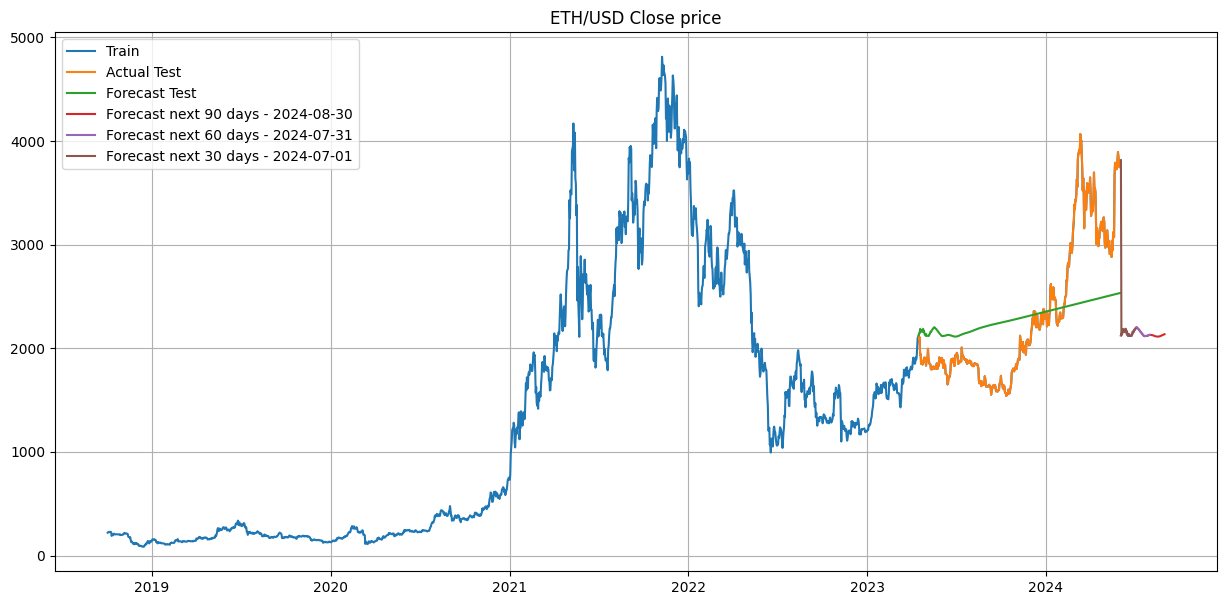

In [48]:
df_forecast_90 = df_results.loc[:, ['Close_forecast']].copy()
df_forecast_90.index = pd.to_datetime(df_forecast_90.index)

df_forecast_60 = df_forecast_90.head(60)
df_forecast_30 = df_forecast_90.head(30)

# Add last value of the original dataset to the forecast 30 days
df_forecast_30.loc[df_filtered.index[-1]] = df_filtered.tail(1).values[0][0]
df_forecast_30 = df_forecast_30.sort_index()

# Label the forecasted data
forecast_30_label = f"Forecast next 30 days - " + df_forecast_30.index[-1].strftime("%Y-%m-%d")
forecast_60_label = f"Forecast next 60 days - " + df_forecast_60.index[-1].strftime("%Y-%m-%d")
forecast_90_label = f"Forecast next 90 days - " + df_forecast_90.index[-1].strftime("%Y-%m-%d")

# Add last day of original data to the forecasted data
df_forecast_30 = pd.concat([df_filtered.tail(1), df_forecast_30])
df_forecast_30.index = pd.date_range(start=df_filtered.index.max(), periods=len(df_forecast_30))

# Plot the overall with connection to forecast
plt.figure(figsize=(15, 7))
plt.plot(df_filtered['Close'], label='Train')
plt.plot(df_test.index, df_test['Close'], label='Actual Test')
plt.plot(forecast_test_valid.index, forecast_test_valid['Close_forecast'], label='Forecast Test')
plt.plot(df_forecast_90.index, df_forecast_90['Close_forecast'], label=forecast_90_label)
plt.plot(df_forecast_60.index, df_forecast_60['Close_forecast'], label=forecast_60_label)
plt.plot(df_forecast_30.index, df_forecast_30['Close_forecast'], label=forecast_30_label)
plt.title('ETH/USD Close price')
plt.grid()
plt.legend()
plt.show()

In [49]:
# Model Evaluation
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))
    return rmse, mape, smape

# Calculate metrics
rmse, mape, smape = calculate_metrics(df_test['Close'], forecast_test_valid['Close_forecast'])
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"SMAPE: {smape:.2f}")

RMSE: 575.95
MAPE: 19.87
SMAPE: 19.47
